In [2]:
import sys
import os
import pandas as pd
import shap
import joblib
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# 1. Configuración para importar módulos de 'src'
# Añadimos la carpeta raíz al path para que Python encuentre 'src'
sys.path.append(os.path.abspath('..'))

from src.preprocessing import load_data, clean_dataframe, split_features_target

In [4]:
# 2. Cargar el Modelo Entrenado y los Datos
# Asumimos que ya ejecutaste 'train.py' y tienes el .pkl
model_path = "../final_model.pkl"
data_path = "../data/adult.csv" # O la ruta que tengas en config

if not os.path.exists(model_path):
    print("❌ Error: No existe final_model.pkl. Ejecuta 'uv run python -m src.train' primero.")
else:
    full_pipeline = joblib.load(model_path)
    print("✅ Modelo cargado correctamente.")

✅ Modelo cargado correctamente.


In [5]:
# 3. Cargar y Limpiar una muestra de datos
# Usamos TUS funciones de src para asegurar que la limpieza es idéntica al entrenamiento
df_raw = load_data(data_path)
df_clean = clean_dataframe(df_raw)
X, y = split_features_target(df_clean, "income")

# Tomamos una muestra aleatoria (SHAP es lento con 30k filas, usamos 1000 para probar)
X_sample = X.sample(1000, random_state=42)

print(f"📊 Analizando una muestra de {X_sample.shape[0]} individuos.")

   csv cargando desde: ../data/adult.csv
   🧹 Filas duplicadas eliminadas: 3465
📊 Analizando una muestra de 1000 individuos.


In [6]:
# 4. Separar el Pipeline en dos partes: Preprocesador y Modelo
# El pipeline tiene pasos: ['preprocessor', 'classifier']
preprocessor = full_pipeline.named_steps['preprocessor']
model_xgboost = full_pipeline.named_steps['classifier']

In [7]:
# 5. Transformar los datos ANTES de dárselos a SHAP
# SHAP necesita números (matriz transformada), no categorías en texto.
print("🔄 Transformando datos con el preprocesador...")
X_transformed = preprocessor.transform(X_sample)

🔄 Transformando datos con el preprocesador...


In [9]:
# 6. Recuperar los nombres de las columnas (Feature Names)
# Esto es vital para que el gráfico diga "Age" y no "Feature 0"
try:
    feature_names = preprocessor.get_feature_names_out()
except:
    # Plan B si falla lo automático: recuperar nombres de numéricos y categóricos
    print("⚠️ Usando recuperación manual de nombres...")
    num_cols = X.select_dtypes(include=['number']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object']).columns.tolist()
    # Accedemos al OneHotEncoder dentro del ColumnTransformer
    ohe = preprocessor.named_transformers_['cat'].named_steps['encoder']
    cat_names = ohe.get_feature_names_out(cat_cols)
    feature_names = num_cols + list(cat_names)

🧠 Calculando valores SHAP (Modo Universal)...


  0%|          | 0/1000 [00:00<?, ?it/s]

✅ ¡Cálculo SHAP completado!

📈 Generando Gráfico de Impacto Global...


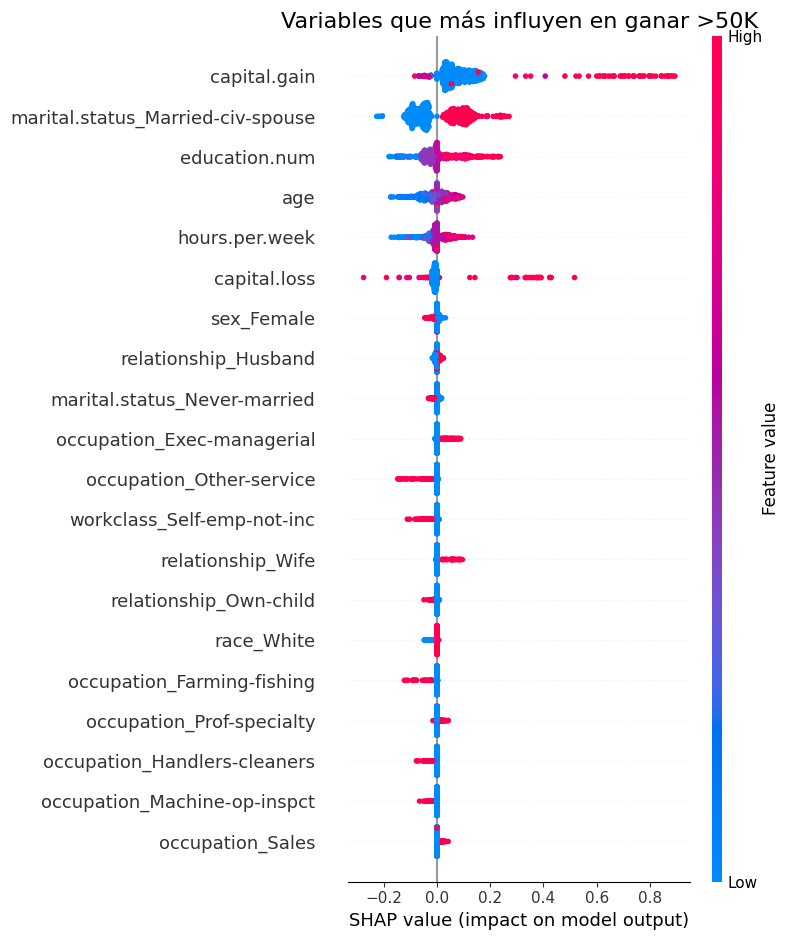

In [ ]:
# 7. Calcular valores SHAP (Método Universal / Agnostic)
print("🧠 Calculando valores SHAP (Modo Universal)...")

# TRUCO: En lugar de pasar el modelo entero, pasamos la FUNCIÓN de predicción.
# Esto evita el error de versiones internas porque SHAP no "abre" el modelo.
# Usamos predict_proba para ver la probabilidad exacta de ser clase 1 (>50K).
predict_fn = lambda x: model_xgboost.predict_proba(x)[:, 1]

# Usamos una muestra pequeña para calibrar (background dataset)
# Esto sirve de referencia para que SHAP sepa qué es "lo normal".
X_background = shap.kmeans(X_transformed, 50) 

# Creamos el explicador genérico (KernelExplainer)
explainer = shap.KernelExplainer(predict_fn, X_background)

# Calculamos los valores SHAP para nuestra muestra
# Nota: KernelExplainer es más lento, por eso es bueno mantener X_sample en 100-200 filas si tienes prisa.
# Si ves que tarda mucho, reduce X_sample en el paso anterior.
shap_values = explainer.shap_values(X_transformed)

print("✅ ¡Cálculo SHAP completado!")


📈 Generando Gráfico de Impacto Global...


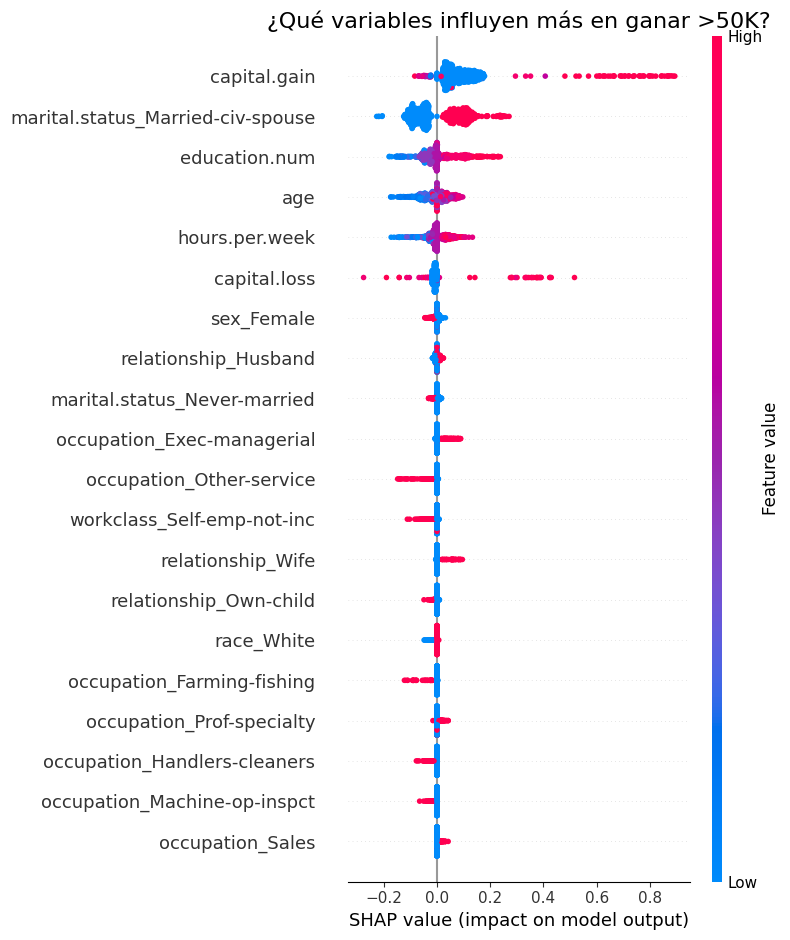

In [13]:
# 8. Generar el Gráfico Summary Plot
print("\n📈 Generando Gráfico de Impacto Global...")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_transformed, feature_names=feature_names, show=False)
plt.title("¿Qué variables influyen más en ganar >50K?", fontsize=16)
plt.tight_layout()
plt.show()